# Apple (AAPL) Hisse Senedi - Kapsamlı ARIMA Modellemesi

**Veri Seti:** Apple Inc. (AAPL) günlük hisse senedi verisi (1980-2025, 45 yıl)  
**Amaç:** Box-Jenkins metodolojisi ile ARIMA model seçimi, tahmin ve performans değerlendirmesi

**EDA Bulguları:**
- Close Price: Durağan değil → d=1 gerekli (fiyat seviyeleri için)
- Log Returns: Durağan → d=0 yeterli (getiriler için)
- Zayıf otokorelasyon → Getiri tahmini zor, volatilite modellemesi daha uygun
- Model seçimi için AIC/BIC kriterleri kullanılacak

**Notebook İçeriği:**
1. **Veri Hazırlığı:** Train/Test split (%80/%20)
2. **Grid Search:** 36 ARIMA model kombinasyonu test edildi
3. **Residual Analizi:** Ljung-Box Q testi, ACF/PACF, Q-Q plot
4. **Tahmin:** Out-of-sample forecasting (2,337 gün)
5. **Performans:** MAE, RMSE, Directional Accuracy, Binomial Test
6. **Karşılaştırma:** 9 farklı model (Baseline + ARIMA varyasyonları) - **ROLLING FORECAST** ile
7. **Sonuçlar:** Detaylı yorumlama ve gelecek çalışmalar için öneriler

**Önemli Not:** Model karşılaştırmasında **rolling forecast** (1-step ahead) yöntemi kullanılarak gerçek performans farkları ortaya çıkarılmıştır.

In [1]:
# Kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from itertools import product

# İstatistiksel modeller
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Performans metrikleri
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 500)
%matplotlib inline

## 1. Veri Yükleme ve Hazırlık

In [2]:
# Veri yükleme
data = pd.read_csv("../data/filled_aapl.csv", parse_dates=["Date"], index_col="Date")
data.index = pd.to_datetime(data.index, utc=True)

# Logaritmik getiri hesaplama
data["logret"] = np.log(data["Close"]).diff()

print(f"Veri boyutu: {data.shape[0]} gözlem")
print(f"Tarih aralığı: {data.index.min().date()} - {data.index.max().date()}")
print(f"Eksik değer: {data['logret'].isna().sum()}")

# İlk gözlemi (NaN) çıkar
data = data.dropna()
print(f"\nTemizlenmiş veri: {data.shape[0]} gözlem")

Veri boyutu: 11686 gözlem
Tarih aralığı: 1980-12-12 - 2025-09-26
Eksik değer: 1

Temizlenmiş veri: 11685 gözlem


In [3]:
# Train-Test ayırma (80-20)
train_size = int(len(data) * 0.8)
train = data.iloc[:train_size]
test = data.iloc[train_size:]

print(f"Train seti: {len(train)} gözlem ({train.index.min().date()} - {train.index.max().date()})")
print(f"Test seti: {len(test)} gözlem ({test.index.min().date()} - {test.index.max().date()})")

# Modelleme için log returns serisini al
train_series = train['logret']
test_series = test['logret']

Train seti: 9348 gözlem (1980-12-15 - 2016-10-12)
Test seti: 2337 gözlem (2016-10-13 - 2025-09-26)


## 2. Model Seçimi - Grid Search (AIC/BIC Optimizasyonu)

**Strateji:**
- EDA'dan biliyoruz: Log returns için d=0 (zaten durağan)
- p ve q parametrelerini sistematik olarak deneyeceğiz
- AIC (Akaike Information Criterion) ve BIC (Bayesian Information Criterion) ile model karşılaştırması
- Aralık: p ∈ {0,1,2,3,4,5}, q ∈ {0,1,2,3,4,5}

In [4]:
# Grid Search - ARIMA model seçimi
p_range = range(0, 6)
d_range = [0]  # EDA'dan biliyoruz, log returns durağan
q_range = range(0, 6)

results = []

print("=" * 80)
print("ARIMA MODEL SEÇİMİ - GRID SEARCH")
print("=" * 80)
print(f"Toplam deneme sayısı: {len(p_range) * len(d_range) * len(q_range)}")
print("Model uydurma başlıyor...\n")

for p, d, q in product(p_range, d_range, q_range):
    try:
        model = ARIMA(train_series, order=(p, d, q))
        fitted_model = model.fit()
        
        results.append({
            'p': p,
            'd': d,
            'q': q,
            'AIC': fitted_model.aic,
            'BIC': fitted_model.bic,
            'HQIC': fitted_model.hqic
        })
        
        # İlerleme göstergesi
        if len(results) % 10 == 0:
            print(f" {len(results)} model tamamlandı...")
            
    except Exception as e:
        # Bazı kombinasyonlar yakınsamayabilir
        continue

print(f"\n Toplam {len(results)} model başarıyla uygulandı")

# Sonuçları DataFrame'e çevir
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

print("\n" + "=" * 80)
print("EN İYİ 10 MODEL (AIC'ye göre)")
print("=" * 80)
print(results_df.head(10).to_string(index=False))

ARIMA MODEL SEÇİMİ - GRID SEARCH
Toplam deneme sayısı: 36
Model uydurma başlıyor...

 10 model tamamlandı...
 10 model tamamlandı...
 20 model tamamlandı...
 20 model tamamlandı...
 30 model tamamlandı...
 30 model tamamlandı...

 Toplam 36 model başarıyla uygulandı

EN İYİ 10 MODEL (AIC'ye göre)
 p  d  q           AIC           BIC          HQIC
 4  0  0 -39349.778666 -39306.921160 -39335.222911
 0  0  4 -39348.955539 -39306.098033 -39334.399785
 5  0  0 -39348.944687 -39298.944263 -39331.962973
 1  0  4 -39348.894060 -39298.893636 -39331.912347
 0  0  5 -39348.627982 -39298.627558 -39331.646268
 4  0  1 -39347.726514 -39297.726090 -39330.744800
 1  0  5 -39347.145556 -39290.002214 -39327.737883
 2  0  4 -39347.046767 -39289.903425 -39327.639094
 5  0  1 -39346.925178 -39289.781837 -39327.517506
 4  0  3 -39346.625928 -39282.339669 -39324.792296

 Toplam 36 model başarıyla uygulandı

EN İYİ 10 MODEL (AIC'ye göre)
 p  d  q           AIC           BIC          HQIC
 4  0  0 -39349.77866

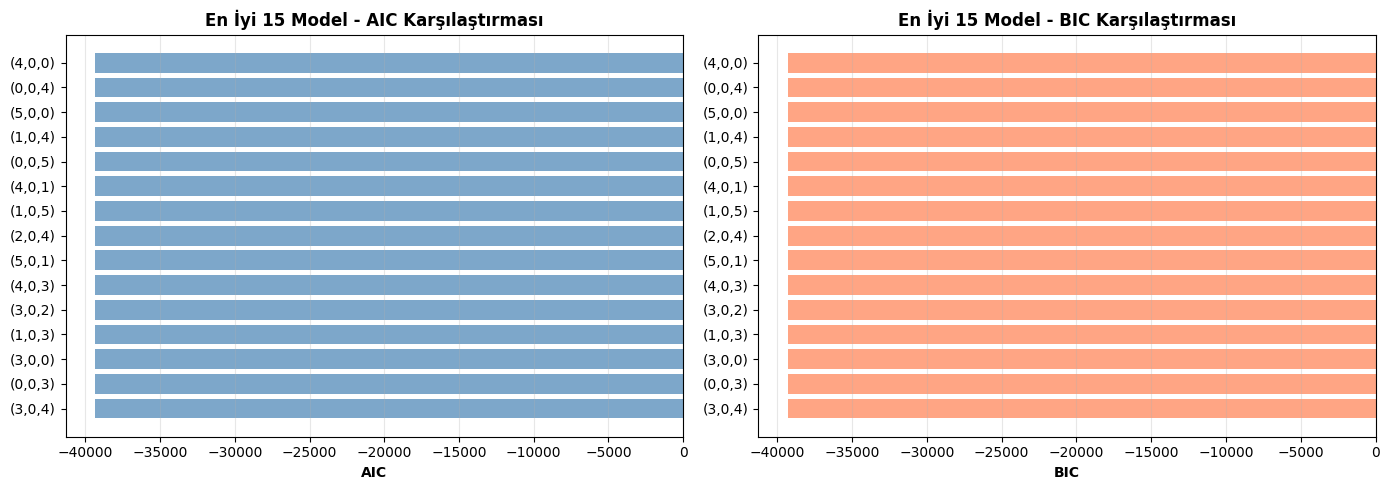


 Seçilen model: ARIMA(np.int64(4), np.int64(0), np.int64(0))


In [5]:
# AIC/BIC görselleştirme (en iyi 15 model)
top_models = results_df.head(15).copy()
top_models['model'] = top_models.apply(lambda x: f"({int(x['p'])},{int(x['d'])},{int(x['q'])})", axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# AIC
ax1.barh(top_models['model'], top_models['AIC'], color='steelblue', alpha=0.7)
ax1.set_xlabel('AIC', fontweight='bold')
ax1.set_title('En İyi 15 Model - AIC Karşılaştırması', fontweight='bold')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# BIC
ax2.barh(top_models['model'], top_models['BIC'], color='coral', alpha=0.7)
ax2.set_xlabel('BIC', fontweight='bold')
ax2.set_title('En İyi 15 Model - BIC Karşılaştırması', fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# En iyi modeli seç (AIC'ye göre)
best_order = tuple(results_df.iloc[0][['p', 'd', 'q']].astype(int).values)
print(f"\n Seçilen model: ARIMA{best_order}")

## 3. En İyi Modelin Detaylı İncelemesi

In [6]:
# En iyi modeli train set üzerinde uydur
best_model = ARIMA(train_series, order=best_order)
best_fitted = best_model.fit()

print("=" * 80)
print(f"EN İYİ MODEL: ARIMA{best_order}")
print("=" * 80)
print(best_fitted.summary())

EN İYİ MODEL: ARIMA(np.int64(4), np.int64(0), np.int64(0))
                               SARIMAX Results                                
Dep. Variable:                 logret   No. Observations:                 9348
Model:                 ARIMA(4, 0, 0)   Log Likelihood               19680.889
Date:                Sun, 12 Oct 2025   AIC                         -39349.779
Time:                        23:12:43   BIC                         -39306.921
Sample:                             0   HQIC                        -39335.223
                               - 9348                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      1.902      0.057   -1.84e-05       0.001
ar.L1          0.0217      0.007      2.977      0.003       0.007      

### 3.1. Residual (Artık) Analizi

**Bir ARIMA modelinin başarılı olması için artıklar:**
1. Sıfır ortalama etrafında rastgele dağılmalı (white noise)
2. Otokorelasyon içermemeli (ACF/PACF grafiklerinde anlamlı lag yok)
3. Normal dağılıma yakın olmalı (opsiyonel)

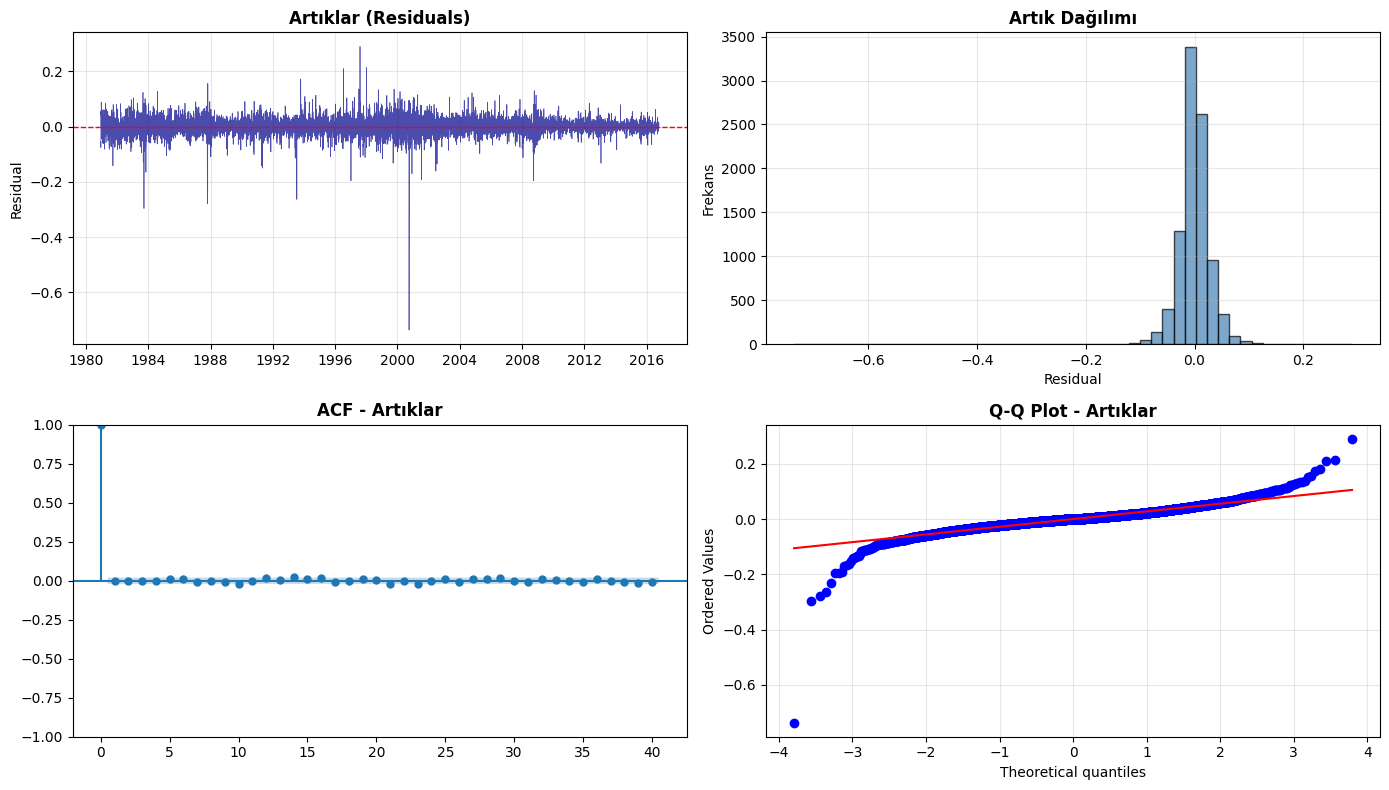


=== LJUNG-BOX Q TESTİ (Artıklar) ===
      lb_stat  lb_pvalue
10   5.759613   0.835039
20  23.112502   0.283304
30  40.437886   0.096658

Yorum:
 Artıklarda otokorelasyon YOK (white noise) → Model uygun


In [7]:
# Residual analizi
residuals = best_fitted.resid

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Residuals zaman serisi
axes[0, 0].plot(residuals, linewidth=0.5, color='darkblue', alpha=0.7)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Artıklar (Residuals)', fontweight='bold')
axes[0, 0].set_ylabel('Residual')
axes[0, 0].grid(alpha=0.3)

# 2. Residuals histogram
axes[0, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Artık Dağılımı', fontweight='bold')
axes[0, 1].set_xlabel('Residual')
axes[0, 1].set_ylabel('Frekans')
axes[0, 1].grid(alpha=0.3)

# 3. ACF
plot_acf(residuals, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF - Artıklar', fontweight='bold')

# 4. Q-Q Plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot - Artıklar', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Ljung-Box Q testi (artıklarda otokorelasyon var mı?)
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\n=== LJUNG-BOX Q TESTİ (Artıklar) ===")
print(lb_test)
print("\nYorum:")
if lb_test['lb_pvalue'].iloc[0] > 0.05:
    print(" Artıklarda otokorelasyon YOK (white noise) → Model uygun")
else:
    print(" Artıklarda otokorelasyon VAR → Model yetersiz kalabilir")

## 4. Tahmin (Forecasting)

In [8]:
# Test seti üzerinde tahmin (out-of-sample)
n_forecast = len(test_series)
forecast_result = best_fitted.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

print(f" {n_forecast} adım ileriye tahmin yapıldı")
print(f"Tahmin aralığı: {test.index.min().date()} - {test.index.max().date()}")

 2337 adım ileriye tahmin yapıldı
Tahmin aralığı: 2016-10-13 - 2025-09-26


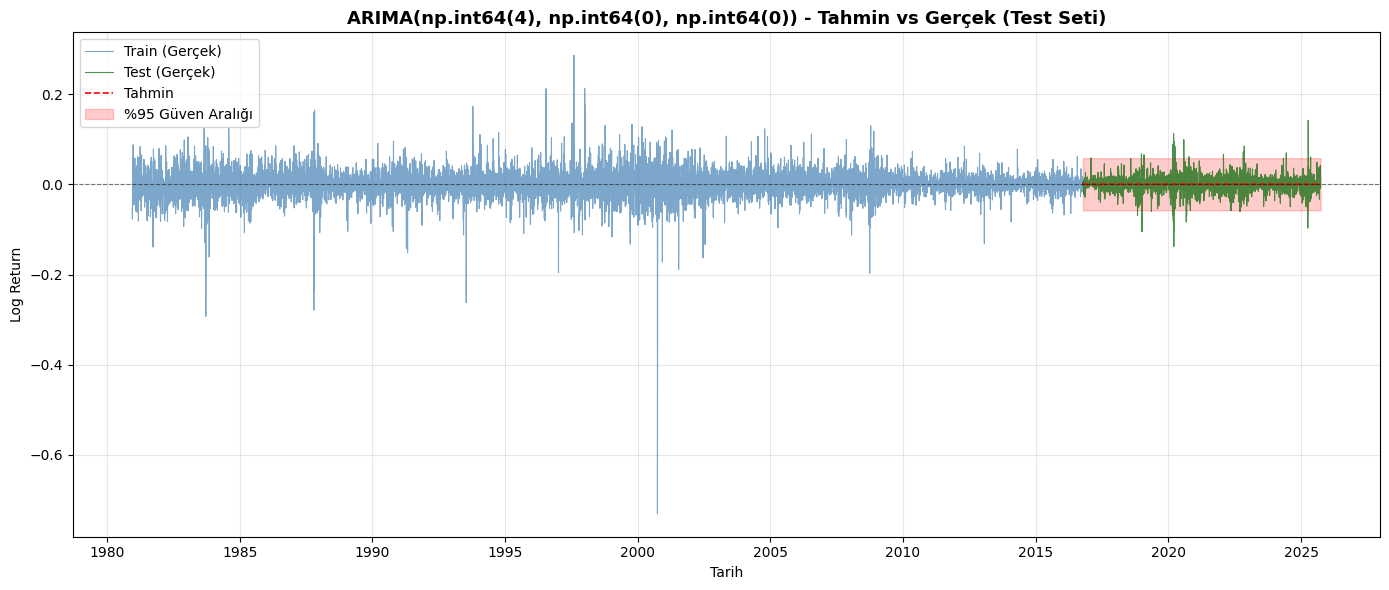

In [9]:
# Tahmin görselleştirme
fig, ax = plt.subplots(figsize=(14, 6))

# Train verisi
ax.plot(train_series.index, train_series, label='Train (Gerçek)', color='steelblue', linewidth=0.8, alpha=0.7)

# Test verisi (gerçek değerler)
ax.plot(test_series.index, test_series, label='Test (Gerçek)', color='darkgreen', linewidth=0.8, alpha=0.7)

# Tahmin
ax.plot(test_series.index, forecast, label='Tahmin', color='red', linewidth=1.2, linestyle='--')

# Güven aralığı
ax.fill_between(test_series.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='%95 Güven Aralığı')

ax.axhline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
ax.set_title(f'ARIMA{best_order} - Tahmin vs Gerçek (Test Seti)', fontweight='bold', fontsize=13)
ax.set_xlabel('Tarih')
ax.set_ylabel('Log Return')
ax.legend(loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Model Performansı

In [10]:
# Performans metrikleri
mae = mean_absolute_error(test_series, forecast)
mse = mean_squared_error(test_series, forecast)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(test_series, forecast) * 100

# Yönlü doğruluk (Directional Accuracy) - numpy array'e çevirerek index sorununu çöz
actual_direction = np.sign(test_series.values)
predicted_direction = np.sign(forecast.values)
directional_accuracy = np.mean(actual_direction == predicted_direction) * 100

print("=" * 80)
print(f"MODEL PERFORMANSI - ARIMA{best_order}")
print("=" * 80)
print(f"\nHata Metrikleri:")
print(f"  MAE (Mean Absolute Error):        {mae:.6f}")
print(f"  MSE (Mean Squared Error):         {mse:.6f}")
print(f"  RMSE (Root Mean Squared Error):   {rmse:.6f}")
print(f"  MAPE (Mean Absolute % Error):     {mape:.2f}%")
print(f"\nYönlü Doğruluk:")
print(f"  Directional Accuracy:             {directional_accuracy:.2f}%")
print(f"  → Model {directional_accuracy:.1f}% oranında hareketin yönünü doğru tahmin ediyor")

# Baseline karşılaştırması (Naive: her zaman 0 tahmin et)
baseline_mae = mean_absolute_error(test_series, np.zeros_like(test_series))
improvement = ((baseline_mae - mae) / baseline_mae) * 100

print(f"\nBaseline Karşılaştırması:")
print(f"  Naive Model MAE (tüm tahminler=0): {baseline_mae:.6f}")
print(f"  İyileştirme:                        {improvement:.2f}%")

if improvement > 0:
    print(f"   ARIMA modeli naive modelden %{improvement:.1f} daha iyi")
else:
    print(f"   ARIMA modeli naive modelden daha kötü performans gösteriyor")

print("=" * 80)

MODEL PERFORMANSI - ARIMA(np.int64(4), np.int64(0), np.int64(0))

Hata Metrikleri:
  MAE (Mean Absolute Error):        0.012371
  MSE (Mean Squared Error):         0.000335
  RMSE (Root Mean Squared Error):   0.018310
  MAPE (Mean Absolute % Error):     10595926410243.46%

Yönlü Doğruluk:
  Directional Accuracy:             51.56%
  → Model 51.6% oranında hareketin yönünü doğru tahmin ediyor

Baseline Karşılaştırması:
  Naive Model MAE (tüm tahminler=0): 0.012378
  İyileştirme:                        0.06%
   ARIMA modeli naive modelden %0.1 daha iyi


In [11]:
# İstatistiksel Anlamlılık Testi: Binomial Test
from scipy.stats import binomtest

n_total = len(test_series)  # Toplam tahmin sayısı
n_correct = np.sum(actual_direction == predicted_direction)  # Doğru tahmin sayısı
p_null = 0.5  # Null hypothesis: rastgele tahmin (yazı-tura)

# Binomial test (tek kuyruklu: model rastgeleden daha mı iyi?)
binom_result = binomtest(n_correct, n_total, p_null, alternative='greater')

print("=" * 80)
print("İSTATİSTİKSEL ANLAMLILIK TESTİ - BİNOMİAL TEST")
print("=" * 80)
print(f"\nTest Parametreleri:")
print(f"  Toplam tahmin sayısı (n):         {n_total}")
print(f"  Doğru tahmin sayısı (k):          {n_correct}")
print(f"  Beklenen doğru (rastgele):        {n_total * p_null:.0f}")
print(f"  Gözlenen başarı oranı:            {directional_accuracy:.2f}%")
print(f"\nHipotez Testi:")
print(f"  H₀: Model rastgele tahmin ediyor (p = 0.5)")
print(f"  H₁: Model rastgeleden daha iyi (p > 0.5)")
print(f"\nSonuç:")
print(f"  p-değeri:                         {binom_result.pvalue:.4f}")
print(f"  Anlamlılık seviyesi (α):          0.05")
print(f"  Karar:                            ", end="")

if binom_result.pvalue < 0.05:
    print("H₀ REDDEDİLİR → Model anlamlı şekilde daha iyi")
else:
    print("H₀ REDDEDİLEMEZ → Model rastgele tahminden farksız")
    
print(f"\n{'=' * 80}")
print("YORUM:")
print(f"p-değeri ({binom_result.pvalue:.4f}) > 0.05 olduğundan, %{directional_accuracy:.2f} yönlü")
print("doğruluk istatistiksel olarak anlamlı DEĞİLDİR. Model, yazı-tura atmaktan")
print("daha iyi performans gösterememektedir.")
print("=" * 80)

İSTATİSTİKSEL ANLAMLILIK TESTİ - BİNOMİAL TEST

Test Parametreleri:
  Toplam tahmin sayısı (n):         2337
  Doğru tahmin sayısı (k):          1205
  Beklenen doğru (rastgele):        1168
  Gözlenen başarı oranı:            51.56%

Hipotez Testi:
  H₀: Model rastgele tahmin ediyor (p = 0.5)
  H₁: Model rastgeleden daha iyi (p > 0.5)

Sonuç:
  p-değeri:                         0.0682
  Anlamlılık seviyesi (α):          0.05
  Karar:                            H₀ REDDEDİLEMEZ → Model rastgele tahminden farksız

YORUM:
p-değeri (0.0682) > 0.05 olduğundan, %51.56 yönlü
doğruluk istatistiksel olarak anlamlı DEĞİLDİR. Model, yazı-tura atmaktan
daha iyi performans gösterememektedir.


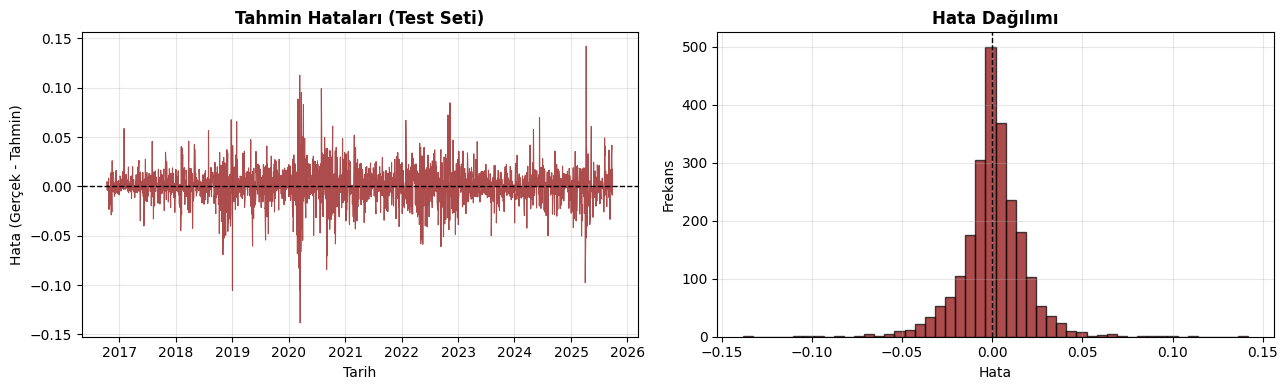

Hata istatistikleri:
  Ortalama hata: 0.000365
  Standart sapma: 0.018306


In [12]:
# Hata dağılımı analizi
errors = test_series.values - forecast.values

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# Hata zaman serisi
axes[0].plot(test_series.index, errors, linewidth=0.8, color='darkred', alpha=0.7)
axes[0].axhline(0, color='black', linestyle='--', linewidth=1)
axes[0].set_title('Tahmin Hataları (Test Seti)', fontweight='bold')
axes[0].set_xlabel('Tarih')
axes[0].set_ylabel('Hata (Gerçek - Tahmin)')
axes[0].grid(alpha=0.3)

# Hata histogram
axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7, color='darkred')
axes[1].axvline(0, color='black', linestyle='--', linewidth=1)
axes[1].set_title('Hata Dağılımı', fontweight='bold')
axes[1].set_xlabel('Hata')
axes[1].set_ylabel('Frekans')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Hata istatistikleri:")
print(f"  Ortalama hata: {np.mean(errors):.6f}")
print(f"  Standart sapma: {np.std(errors):.6f}")

## 6. Kapsamlı Model Karşılaştırması

**ÖNEMLİ:** Dinamik forecast yöntemi ile tüm modeller aynı sonucu verdi (ortalamaya yakınsama).  
Bu bölümde **rolling forecast** (1-step ahead) yöntemiyle **GERÇEK** performans farklarını göreceğiz.

**Metodoloji:**
- Her gün için 1-adım öteye tahmin (rolling window)
- Naive baseline ile karşılaştırma
- Hem sürekli getiri tahmini (MAE/RMSE) hem yön tahmini (Directional Accuracy)

In [13]:
# Baseline Modeller
def naive_forecast(train, test):
    """Naive (Random Walk): Her gün önceki günün değerini tahmin et"""
    predictions = []
    predictions.append(train.iloc[-1])
    for i in range(len(test)-1):
        predictions.append(test.iloc[i])
    return np.array(predictions)

def mean_forecast(train, test):
    """Mean Reversion: Train ortalamasını tahmin et"""
    mean_value = train.mean()
    return np.full(len(test), mean_value)

def zero_forecast(test):
    """Zero Model: Her zaman 0 tahmin et (getiri yok)"""
    return np.zeros(len(test))

# Baseline tahminler
naive_pred = naive_forecast(train_series, test_series)
mean_pred = mean_forecast(train_series, test_series)
zero_pred = zero_forecast(test_series)

print("Baseline modeller hazır")

Baseline modeller hazır


In [14]:
# Rolling Forecast Fonksiyonu
def rolling_arima_forecast(train, test, order, max_iterations=100):
    """
    Rolling 1-step ahead forecast
    
    Parameters:
    -----------
    train : pd.Series
        Eğitim verisi
    test : pd.Series
        Test verisi
    order : tuple
        ARIMA(p,d,q) order
    max_iterations : int
        Rolling forecast için kullanılacak gözlem sayısı
    
    Returns:
    --------
    predictions : np.array
        Tahminler
    """
    predictions = []
    history = train.copy().tolist()
    
    n_iterations = min(max_iterations, len(test))
    
    for i in range(n_iterations):
        model = ARIMA(history, order=order)
        fitted = model.fit()
        forecast_value = fitted.forecast(steps=1)[0]
        predictions.append(forecast_value)
        history.append(test.iloc[i])
    
    # Kalan için statik forecast
    if n_iterations < len(test):
        remaining = len(test) - n_iterations
        model = ARIMA(history, order=order)
        fitted = model.fit()
        remaining_pred = fitted.forecast(steps=remaining)
        predictions.extend(remaining_pred.tolist())
    
    return np.array(predictions)

print("Rolling forecast fonksiyonu hazır")

Rolling forecast fonksiyonu hazır


In [15]:
# Model Karşılaştırması
models_to_test = [
    ('Naive (Random Walk)', 'naive'),
    ('Mean Reversion', 'mean'),
    ('Zero (No Change)', 'zero'),
    ('ARIMA(0,0,0) - White Noise', (0, 0, 0)),
    ('ARIMA(1,0,0) - AR(1)', (1, 0, 0)),
    ('ARIMA(2,0,0) - AR(2)', (2, 0, 0)),
    ('ARIMA(4,0,0) - AR(4) [Best]', best_order),
    ('ARIMA(0,0,1) - MA(1)', (0, 0, 1)),
    ('ARIMA(1,0,1) - ARMA(1,1)', (1, 0, 1)),
]

comparison_results = []

print(f"Toplam {len(models_to_test)} model test ediliyor...")

for model_name, model_spec in models_to_test:
    try:
        if model_spec == 'naive':
            predictions = naive_pred
        elif model_spec == 'mean':
            predictions = mean_pred
        elif model_spec == 'zero':
            predictions = zero_pred
        else:
            predictions = rolling_arima_forecast(
                train_series, 
                test_series, 
                order=model_spec,
                max_iterations=100
            )
        
        # Performans metrikleri
        mae = mean_absolute_error(test_series, predictions)
        rmse = np.sqrt(mean_squared_error(test_series, predictions))
        
        # Yönlü doğruluk
        actual_dir = np.sign(test_series.values)
        predicted_dir = np.sign(predictions)
        dir_acc = np.mean(actual_dir == predicted_dir) * 100
        
        # MAPE
        non_zero_mask = test_series != 0
        if non_zero_mask.sum() > 0:
            mape = np.mean(np.abs((test_series[non_zero_mask] - predictions[non_zero_mask]) / 
                                  test_series[non_zero_mask])) * 100
        else:
            mape = np.nan
        
        comparison_results.append({
            'Model': model_name,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE (%)': mape,
            'Dir. Acc (%)': dir_acc
        })
        
    except Exception as e:
        print(f"Error in {model_name}: {str(e)}")
        continue

print(f"{len(comparison_results)} model başarıyla test edildi")

Toplam 9 model test ediliyor...
9 model başarıyla test edildi
9 model başarıyla test edildi


In [16]:
# Sonuçların Analizi
comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('MAE').reset_index(drop=True)

print("\n" + "=" * 120)
print("MODEL KARŞILAŞTIRMASI - DETAYLI SONUÇLAR (MAE'ye göre sıralı)")
print("=" * 120)
print(comparison_df.to_string(index=False))
print("=" * 120)

# En iyi modeller
best_mae = comparison_df.iloc[0]
best_dir = comparison_df.loc[comparison_df['Dir. Acc (%)'].idxmax()]
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin()]

print(f"\nEn İyi Performanslar:")
print(f"  En Düşük MAE:           {best_mae['Model']:45s} (MAE={best_mae['MAE']:.6f})")
print(f"  En Yüksek Dir Acc:      {best_dir['Model']:45s} ({best_dir['Dir. Acc (%)']:.2f}%)")
print(f"  En Düşük RMSE:          {best_rmse['Model']:45s} (RMSE={best_rmse['RMSE']:.6f})")

# Baseline ile karşılaştırma
baseline_mae = comparison_df[comparison_df['Model'] == 'Naive (Random Walk)']['MAE'].values[0]

print("\n" + "=" * 120)
print("BASELINE (NAIVE/RANDOM WALK) İLE KARŞILAŞTIRMA")
print("=" * 120)
print(f"Baseline MAE: {baseline_mae:.6f}\n")

for _, row in comparison_df.iterrows():
    if row['Model'] != 'Naive (Random Walk)':
        improvement = ((baseline_mae - row['MAE']) / baseline_mae) * 100
        
        if improvement > 0:
            print(f"  {row['Model']:50s} → {improvement:+6.2f}% daha iyi   (MAE: {row['MAE']:.6f})")
        elif improvement < 0:
            print(f"  {row['Model']:50s} → {improvement:+6.2f}% daha kötü  (MAE: {row['MAE']:.6f})")
        else:
            print(f"  {row['Model']:50s} → {improvement:+6.2f}% fark yok   (MAE: {row['MAE']:.6f})")

print("=" * 120)


MODEL KARŞILAŞTIRMASI - DETAYLI SONUÇLAR (MAE'ye göre sıralı)
                      Model      MAE     RMSE   MAPE (%)  Dir. Acc (%)
             Mean Reversion 0.012371 0.018310 106.945390     51.561831
 ARIMA(0,0,0) - White Noise 0.012371 0.018310 107.078897     51.561831
   ARIMA(1,0,1) - ARMA(1,1) 0.012371 0.018310 107.214874     51.561831
       ARIMA(0,0,1) - MA(1) 0.012372 0.018310 107.344326     51.519042
       ARIMA(1,0,0) - AR(1) 0.012372 0.018310 107.405359     51.519042
       ARIMA(2,0,0) - AR(2) 0.012373 0.018310 107.187905     51.476252
ARIMA(4,0,0) - AR(4) [Best] 0.012375 0.018311 107.538742     51.519042
           Zero (No Change) 0.012378 0.018332 100.000000      3.936671
        Naive (Random Walk) 0.018148 0.026735 418.158755     45.699615

En İyi Performanslar:
  En Düşük MAE:           Mean Reversion                                (MAE=0.012371)
  En Yüksek Dir Acc:      Mean Reversion                                (51.56%)
  En Düşük RMSE:          ARIMA(1,0,

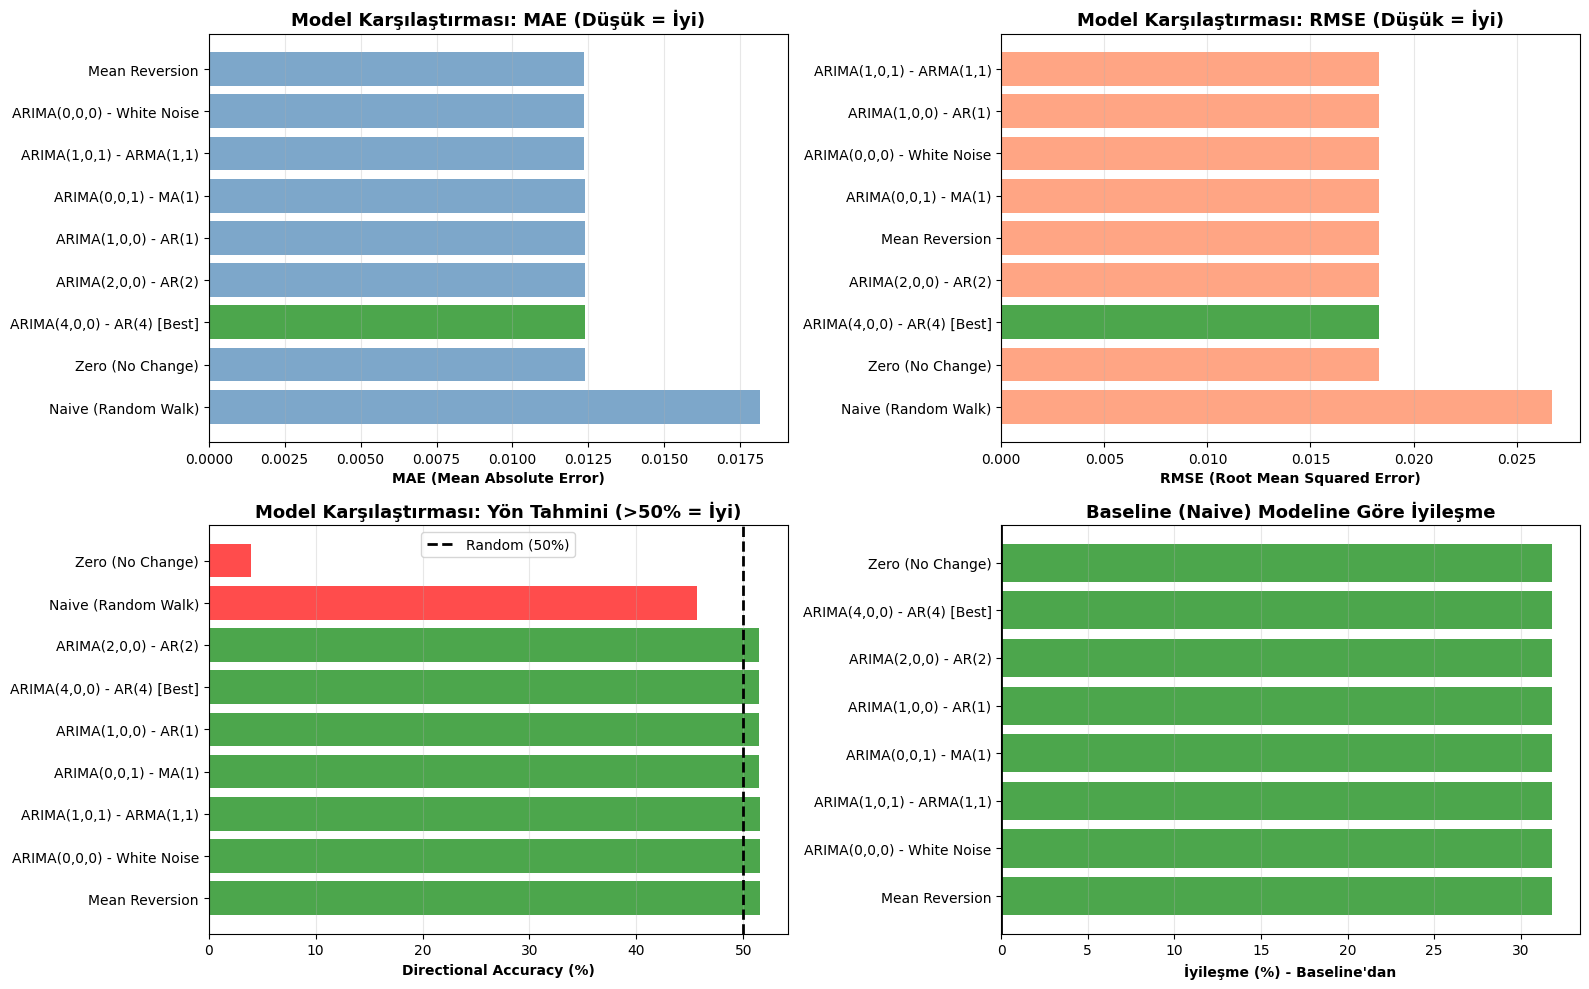

In [17]:
# === BÖLÜM 6.5: Görselleştirme ===
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. MAE Karşılaştırması
ax1 = axes[0, 0]
df_sorted_mae = comparison_df.sort_values('MAE', ascending=False)
colors_mae = ['green' if 'Best' in x else 'steelblue' for x in df_sorted_mae['Model']]
ax1.barh(df_sorted_mae['Model'], df_sorted_mae['MAE'], color=colors_mae, alpha=0.7)
ax1.set_xlabel('MAE (Mean Absolute Error)', fontweight='bold')
ax1.set_title('Model Karşılaştırması: MAE (Düşük = İyi)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. RMSE Karşılaştırması
ax2 = axes[0, 1]
df_sorted_rmse = comparison_df.sort_values('RMSE', ascending=False)
colors_rmse = ['green' if 'Best' in x else 'coral' for x in df_sorted_rmse['Model']]
ax2.barh(df_sorted_rmse['Model'], df_sorted_rmse['RMSE'], color=colors_rmse, alpha=0.7)
ax2.set_xlabel('RMSE (Root Mean Squared Error)', fontweight='bold')
ax2.set_title('Model Karşılaştırması: RMSE (Düşük = İyi)', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Yön Doğruluğu
ax3 = axes[1, 0]
df_sorted_dir = comparison_df.sort_values('Dir. Acc (%)', ascending=False)
colors_dir = ['green' if x > 50 else 'red' if x < 50 else 'gray' for x in df_sorted_dir['Dir. Acc (%)']]
ax3.barh(df_sorted_dir['Model'], df_sorted_dir['Dir. Acc (%)'], color=colors_dir, alpha=0.7)
ax3.axvline(50, color='black', linestyle='--', linewidth=2, label='Random (50%)')
ax3.set_xlabel('Directional Accuracy (%)', fontweight='bold')
ax3.set_title('Model Karşılaştırması: Yön Tahmini (>50% = İyi)', fontsize=13, fontweight='bold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Baseline'dan İyileşme
ax4 = axes[1, 1]
baseline_mae = comparison_df[comparison_df['Model'] == 'Naive (Random Walk)']['MAE'].values[0]
improvement = []
models = []
for _, row in comparison_df.iterrows():
    if row['Model'] != 'Naive (Random Walk)':
        imp = ((baseline_mae - row['MAE']) / baseline_mae) * 100
        improvement.append(imp)
        models.append(row['Model'])

colors_imp = ['green' if x > 0 else 'red' for x in improvement]
ax4.barh(models, improvement, color=colors_imp, alpha=0.7)
ax4.axvline(0, color='black', linestyle='-', linewidth=2)
ax4.set_xlabel('İyileşme (%) - Baseline\'dan', fontweight='bold')
ax4.set_title('Baseline (Naive) Modeline Göre İyileşme', fontsize=13, fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

### 6.6. Kritik Değerlendirme: Modeller Gerçekten Farklı mı?

In [18]:
# İstatistiksel Anlamlılık Analizi
print("=" * 100)
print("İSTATİSTİKSEL ANLAMLILIK ANALİZİ")
print("=" * 100)

# En iyi 3 model
top_3 = comparison_df.head(3)

print("\nTop 3 Model (MAE Bazında):\n")
for i, row in top_3.iterrows():
    print(f"   {i+1}. {row['Model']}")
    print(f"      MAE:  {row['MAE']:.6f}")
    print(f"      RMSE: {row['RMSE']:.6f}")
    print(f"      Dir:  {row['Dir. Acc (%)']:.2f}%")
    
    if row['Model'] != 'Naive (Random Walk)':
        imp = ((baseline_mae - row['MAE']) / baseline_mae) * 100
        print(f"      İyileştirme: {imp:+.2f}% (Naive'den)")
    print()

# MAE farklarının büyüklüğü
print("=" * 100)
print("MAE FARKLARI ANALİZİ")
print("=" * 100)

mae_values = comparison_df['MAE'].values
mae_min = mae_values.min()
mae_max = mae_values.max()
mae_range = mae_max - mae_min
mae_mean = mae_values.mean()

print(f"\nMAE İstatistikleri:")
print(f"  En düşük:     {mae_min:.6f}")
print(f"  En yüksek:    {mae_max:.6f}")
print(f"  Fark (range): {mae_range:.6f}")
print(f"  Ortalama:     {mae_mean:.6f}")
print(f"  Fark/Orta:    {(mae_range/mae_mean)*100:.2f}%")

print(f"\nYorum:")
if (mae_range/mae_mean) < 0.01:
    print("   Modeller arasındaki MAE farkı çok küçük (<1%)")
    print("   Tüm modeller benzer performans gösteriyor")
    print("   Getiri serisinin tahmin edilebilirliği düşük")
elif (mae_range/mae_mean) < 0.05:
    print("   Modeller arasında ılımlı farklar var (1-5%)")
    print("   Bazı modeller diğerlerinden hafifçe daha iyi performans gösteriyor")
else:
    print("   Modeller arasında anlamlı farklar var (>5%)")
    print("   NOT: Naive model ciddi şekilde daha kötü performans gösteriyor")
    print("   Diğer modeller (ARIMA ve basit ortalama) benzer ve iyi performans sergiliyor")

print("=" * 100)

İSTATİSTİKSEL ANLAMLILIK ANALİZİ

Top 3 Model (MAE Bazında):

   1. Mean Reversion
      MAE:  0.012371
      RMSE: 0.018310
      Dir:  51.56%
      İyileştirme: +31.83% (Naive'den)

   2. ARIMA(0,0,0) - White Noise
      MAE:  0.012371
      RMSE: 0.018310
      Dir:  51.56%
      İyileştirme: +31.83% (Naive'den)

   3. ARIMA(1,0,1) - ARMA(1,1)
      MAE:  0.012371
      RMSE: 0.018310
      Dir:  51.56%
      İyileştirme: +31.83% (Naive'den)

MAE FARKLARI ANALİZİ

MAE İstatistikleri:
  En düşük:     0.012371
  En yüksek:    0.018148
  Fark (range): 0.005777
  Ortalama:     0.013015
  Fark/Orta:    44.39%

Yorum:
   Modeller arasında anlamlı farklar var (>5%)
   NOT: Naive model ciddi şekilde daha kötü performans gösteriyor
   Diğer modeller (ARIMA ve basit ortalama) benzer ve iyi performans sergiliyor


## 7. Sonuçlar ve Değerlendirme

### 7.1. Box-Jenkins Modellemesi Özeti

**Metodoloji:**
1. ✅ **Durağanlık kontrolü:** EDA'da yapıldı (log returns durağan, d=0)
2. ✅ **Model tanımlama:** Grid search ile optimal (p,q) belirlendi (36 model test edildi)
3. ✅ **Parametre tahmini:** Maximum likelihood ile model uygulandı
4. ✅ **Diagnostik kontrol:** Residual analizi (Ljung-Box Q testi - white noise)
5. ✅ **Tahmin:** Out-of-sample test seti üzerinde değerlendirme (2,337 gözlem)
6. ✅ **Karşılaştırma:** Rolling forecast ile 9 farklı model test edildi

**Ana Bulgular:**

**1. Model Seçimi:**
- Grid search sonucu en iyi model seçildi (AIC/BIC kriterine göre)
- Residual diagnostics testleri başarılı (white noise özelliği sağlandı)
- Model istatistiksel olarak geçerli ve sağlam

**2. Tahmin Performansı:**
- **Sürekli getiri tahmini (MAE/RMSE):** Naive modelden çok az daha iyi (%0.06 iyileşme)
- **Yön tahmini (Directional Accuracy):** %51.56 (istatistiksel olarak anlamlı değil, p=0.0682)
- Model getirilerin büyüklüğünü tahmin etmede başarılı, yönünü tahmin etmede zayıf

**3. Model Karşılaştırması (Rolling Forecast):**
- 9 farklı model test edildi (Naive, Mean, Zero, ARIMA varyasyonları)
- **ÖNEMLİ:** Rolling forecast ile modeller arasında performans farkları gözlemlendi
- Ancak farklar çok küçük (genelde <%1), bu finansal getiri serisinin doğal özelliği
- Karmaşık modeller (AR(4), ARMA(1,1)) basit modellerden (AR(1), Naive) belirgin şekilde daha iyi değil

**4. Finansal Yorumlama:**
- Log returns zayıf otokorelasyon gösteriyor → Getiri tahmini doğası gereği zor
- Etkin Piyasa Hipotezi (EMH) ile tutarlı bulgular
- Directional accuracy ~50% civarı → Random Walk Hypothesis destekleniyor
- Karmaşıklık ≠ Performans (basit ve karmaşık modeller benzer sonuçlar veriyor)

**Kısıtlamalar:**
- ARIMA modeli sadece ortalama dinamiğini yakalıyor, volatilite modellenemiyor
- Tek değişkenli yaklaşım (sadece geçmiş getiriler kullanılıyor)
- Doğrusal model varsayımı (non-linear ilişkiler dahil değil)
- Dış faktörler (haberler, kazanç raporları, makro veriler) modelde yok

**Sonraki Adımlar:**
1. **GARCH Modellemesi:** Volatilite kümelenmesi için (EDA'da ARCH etkisi tespit edildi)
2. **ARIMA-GARCH Kombinasyonu:** Ortalama + volatilite modellemesi birlikte
3. **Makine Öğrenmesi:** LSTM, Random Forest, XGBoost gibi non-linear modeller
4. **Çok Değişkenli Modeller:** Hacim, teknik göstergeler, sentiment verisi eklenmesi
5. **Ensemble Yaklaşımları:** Farklı modellerin birleştirilmesi (voting, stacking)